<a href="https://colab.research.google.com/github/Stephen0111/Financial-forecasting/blob/main/Financial_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# ======================
# INSTALL DEPENDENCIES
# ======================
!pip install yfinance beautifulsoup4 requests vaderSentiment prophet lxml pandas matplotlib plotly selenium


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.0/512.0 kB 36.0 MB/s eta 0:00:00


In [18]:
# ======================
# IMPORT LIBRARIES
# ======================
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import yfinance as yf
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from prophet import Prophet
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")


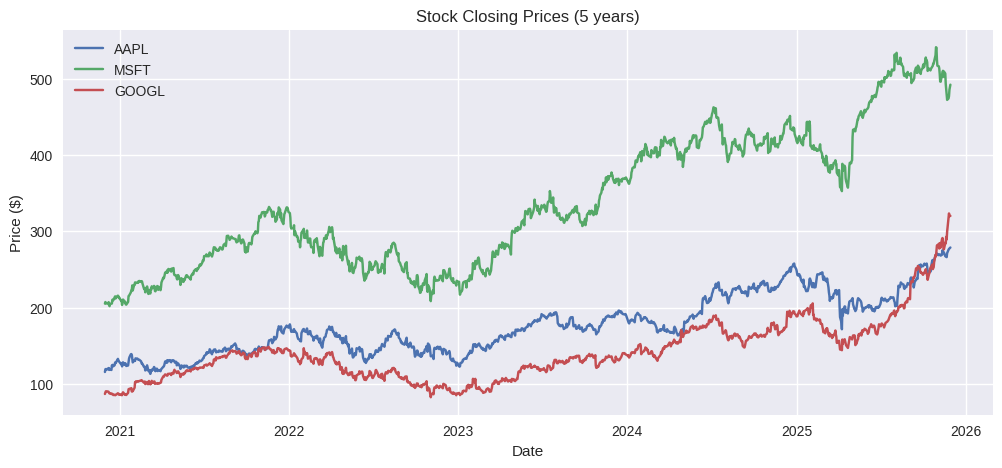

,ds,Open,High,Low,y,Volume,Ticker
0,2020-11-30 00:00:00-05:00,113.864721,117.758530,113.708965,115.889503,169410200,AAPL
1,2020-12-01 00:00:00-05:00,117.797449,120.192141,116.823997,119.462051,127728200,AAPL
2,2020-12-02 00:00:00-05:00,118.780643,120.094810,117.680645,119.812508,89004200,AAPL
3,2020-12-03 00:00:00-05:00,120.240820,120.493920,118.965600,119.676224,78967600,AAPL
4,2020-12-04 00:00:00-05:00,119.345262,119.598361,118.293931,119.004555,78260400,AAPL
5,2020-12-07 00:00:00-05:00,119.062948,121.262952,119.004543,120.464722,86712000,AAPL
6,2020-12-08 00:00:00-05:00,121.068266,121.662073,119.822241,121.077995,82225500,AAPL
7,2020-12-09 00:00:00-05:00,121.224022,122.606322,117.787736,118.547028,115089200,AAPL
8,2020-12-10 00:00:00-05:00,117.300997,120.581534,116.960290,119.968254,81312200,AAPL
9,2020-12-11 00:00:00-05:00,119.179767,119.501008,117.349679,119.160301,86939800,AAPL


In [4]:

# ======================================
# FETCH HISTORICAL STOCK PRICE (5 YEARS)
# ======================================

# Define your tickers
tickers = ["AAPL", "MSFT", "GOOGL"]

# Fetch and combine data
df_list = []
for ticker in tickers:
    df = yf.Ticker(ticker).history(period="5y", interval="1d")
    df = df.reset_index()[["Date", "Open", "High", "Low", "Close", "Volume"]]
    df["Ticker"] = ticker
    df_list.append(df)

# Combine all dataframes
df_price = pd.concat(df_list, ignore_index=True)
df_price.rename(columns={"Date": "ds", "Close": "y"}, inplace=True)

# Visualization
plt.figure(figsize=(12,5))
for ticker in tickers:
    ticker_data = df_price[df_price["Ticker"] == ticker]
    plt.plot(ticker_data["ds"], ticker_data["y"], label=ticker)
plt.title("Stock Closing Prices (5 years)")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.show()

df_price.head(10)

In [23]:
# ===============================
# GET NEWS USING YFINANCE
# ===============================

def get_yahoo_news_api(ticker):
    try:
        url = f"https://query2.finance.yahoo.com/v1/finance/search?q={ticker}&quotesCount=0&newsCount=10"
        headers = {"User-Agent": "Mozilla/5.0"}

        response = requests.get(url, headers=headers)
        data = response.json()

        articles = []
        if "news" in data:
            for item in data["news"]:
                articles.append({
                    "title": item.get("title", ""),
                    "publisher": item.get("publisher", ""),
                    "link": item.get("link", ""),
                    "timestamp": datetime.fromtimestamp(item.get("providerPublishTime", 0)) if item.get("providerPublishTime") else None
                })

        return pd.DataFrame(articles)
    except Exception as e:
        print(f"Error: {e}")
        return pd.DataFrame(columns=["title", "publisher", "link", "timestamp"])

# Test with one ticker first
tickers = ["AAPL", "MSFT", "GOOGL"]
df_news_list = []

for ticker in tickers:
    print(f"Fetching news for {ticker}...")
    df = get_yahoo_news_api(ticker)
    df["ticker"] = ticker
    df_news_list.append(df)
    print(f"  → Got {len(df)} articles")

df_news = pd.concat(df_news_list, ignore_index=True)
print(f"\nTotal articles: {len(df_news)}")
df_news.head(15)

Fetching news for AAPL...
  → Got 10 articles
Fetching news for MSFT...
  → Got 10 articles
Fetching news for GOOGL...
  → Got 10 articles

Total articles: 30


,title,publisher,link,timestamp,ticker
0,Prediction: This Will Be the Next Quantum Computing Stock That Berkshire Hat...,Motley Fool,https://finance.yahoo.com/m/2a193258-84e7-3587-a723-589d08603bf9/prediction%...,2025-11-30 23:30:00,AAPL
1,Which ETF Deserves a Spot in Your Portfolio Right Now?,Motley Fool,https://finance.yahoo.com/m/608c16f7-ad4b-3dcd-9740-a2a34fb6e83f/which-etf-d...,2025-11-30 18:40:00,AAPL
2,"Ranking the Best ""Magnificent Seven"" Stocks to Buy for 2026: Here's My No. 3...",Motley Fool,https://finance.yahoo.com/m/cdd6ec32-a452-3ad2-a80c-814306db9698/ranking-the...,2025-11-30 18:30:00,AAPL
3,Experts Weigh In: Can Apple’s Stock Inch Past $300 per Share Before Year’s End?,GOBankingRates,https://finance.yahoo.com/news/experts-weigh-apple-stock-inch-153905971.html,2025-11-30 15:39:05,AAPL
4,"2 Unstoppable Stocks That Could Join Apple, Nvidia, Microsoft, and Alphabet ...",Motley Fool,https://finance.yahoo.com/m/f44e0b37-563d-38ef-bada-c85a293e87fc/2-unstoppab...,2025-11-30 15:18:00,AAPL
5,Stocks drift back towards record highs as the final month of 2025 gets under...,Yahoo Finance,https://finance.yahoo.com/news/stocks-drift-back-towards-record-highs-as-the...,2025-11-30 12:27:43,AAPL
6,Warren Buffett Dumps Apple and Bank of America to Pile Into This High-Yield ...,Motley Fool,https://finance.yahoo.com/m/b289b0ca-984d-302c-aaaa-24d7c4b55946/warren-buff...,2025-11-30 11:45:00,AAPL
7,Prediction: These 4 Stocks Will Be Worth $5 Trillion by 2028,Motley Fool,https://finance.yahoo.com/m/e3237583-b963-3013-a4ed-7bb9acb95d2e/prediction%...,2025-11-30 11:15:00,AAPL
8,Here Are Billionaire Warren Buffett's 5 Biggest Stock Holdings,Motley Fool,https://finance.yahoo.com/m/a94baacc-4f5b-3c44-976b-e785df632ea4/here-are-bi...,2025-11-30 10:50:00,AAPL
9,"Prediction: This Unstoppable Stock Will Join Nvidia, Apple, Microsoft, and A...",Motley Fool,https://finance.yahoo.com/m/54ff5086-343e-338d-84d8-d097be9489ed/prediction%...,2025-11-30 08:02:00,AAPL


In [24]:
# ===============================
# CLEAN NEWS DATA
# ===============================
df_news["timestamp"] = pd.to_datetime(df_news["timestamp"], errors="coerce")
df_news.drop_duplicates(subset=["title"], inplace=True)
df_news = df_news.dropna(subset=["timestamp"])

df_news.head()


,title,publisher,link,timestamp,ticker
0,Prediction: This Will Be the Next Quantum Computing Stock That Berkshire Hat...,Motley Fool,https://finance.yahoo.com/m/2a193258-84e7-3587-a723-589d08603bf9/prediction%...,2025-11-30 23:30:00,AAPL
1,Which ETF Deserves a Spot in Your Portfolio Right Now?,Motley Fool,https://finance.yahoo.com/m/608c16f7-ad4b-3dcd-9740-a2a34fb6e83f/which-etf-d...,2025-11-30 18:40:00,AAPL
2,"Ranking the Best ""Magnificent Seven"" Stocks to Buy for 2026: Here's My No. 3...",Motley Fool,https://finance.yahoo.com/m/cdd6ec32-a452-3ad2-a80c-814306db9698/ranking-the...,2025-11-30 18:30:00,AAPL
3,Experts Weigh In: Can Apple’s Stock Inch Past $300 per Share Before Year’s End?,GOBankingRates,https://finance.yahoo.com/news/experts-weigh-apple-stock-inch-153905971.html,2025-11-30 15:39:05,AAPL
4,"2 Unstoppable Stocks That Could Join Apple, Nvidia, Microsoft, and Alphabet ...",Motley Fool,https://finance.yahoo.com/m/f44e0b37-563d-38ef-bada-c85a293e87fc/2-unstoppab...,2025-11-30 15:18:00,AAPL


In [25]:

# ======================================
# RUN SENTIMENT ANALYSIS ON HEADLINES
# ======================================
sia = SentimentIntensityAnalyzer()
df_news["sentiment"] = df_news["title"].apply(lambda x: sia.polarity_scores(x)["compound"])

df_news.head()


,title,publisher,link,timestamp,ticker,sentiment
0,Prediction: This Will Be the Next Quantum Computing Stock That Berkshire Hat...,Motley Fool,https://finance.yahoo.com/m/2a193258-84e7-3587-a723-589d08603bf9/prediction%...,2025-11-30 23:30:00,AAPL,0.0000
1,Which ETF Deserves a Spot in Your Portfolio Right Now?,Motley Fool,https://finance.yahoo.com/m/608c16f7-ad4b-3dcd-9740-a2a34fb6e83f/which-etf-d...,2025-11-30 18:40:00,AAPL,0.0000
2,"Ranking the Best ""Magnificent Seven"" Stocks to Buy for 2026: Here's My No. 3...",Motley Fool,https://finance.yahoo.com/m/cdd6ec32-a452-3ad2-a80c-814306db9698/ranking-the...,2025-11-30 18:30:00,AAPL,0.8442
3,Experts Weigh In: Can Apple’s Stock Inch Past $300 per Share Before Year’s End?,GOBankingRates,https://finance.yahoo.com/news/experts-weigh-apple-stock-inch-153905971.html,2025-11-30 15:39:05,AAPL,0.2960
4,"2 Unstoppable Stocks That Could Join Apple, Nvidia, Microsoft, and Alphabet ...",Motley Fool,https://finance.yahoo.com/m/f44e0b37-563d-38ef-bada-c85a293e87fc/2-unstoppab...,2025-11-30 15:18:00,AAPL,0.1027


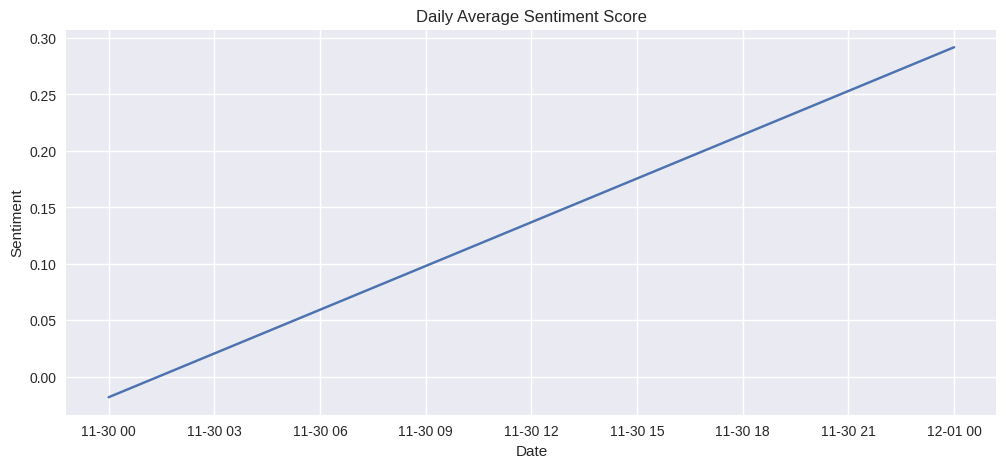

,ds,daily_sentiment
0,2025-11-30,-0.018021
1,2025-12-01,0.291800


In [26]:
# ======================================
# DAILY SENTIMENT AVERAGES
# ======================================
df_news["date"] = df_news["timestamp"].dt.date
df_daily_sent = df_news.groupby("date")["sentiment"].mean().reset_index()
df_daily_sent.rename(columns={"date":"ds", "sentiment":"daily_sentiment"}, inplace=True)

# Visualization
plt.figure(figsize=(12,5))
plt.plot(df_daily_sent["ds"], df_daily_sent["daily_sentiment"])
plt.title("Daily Average Sentiment Score")
plt.xlabel("Date")
plt.ylabel("Sentiment")
plt.show()

df_daily_sent.head()


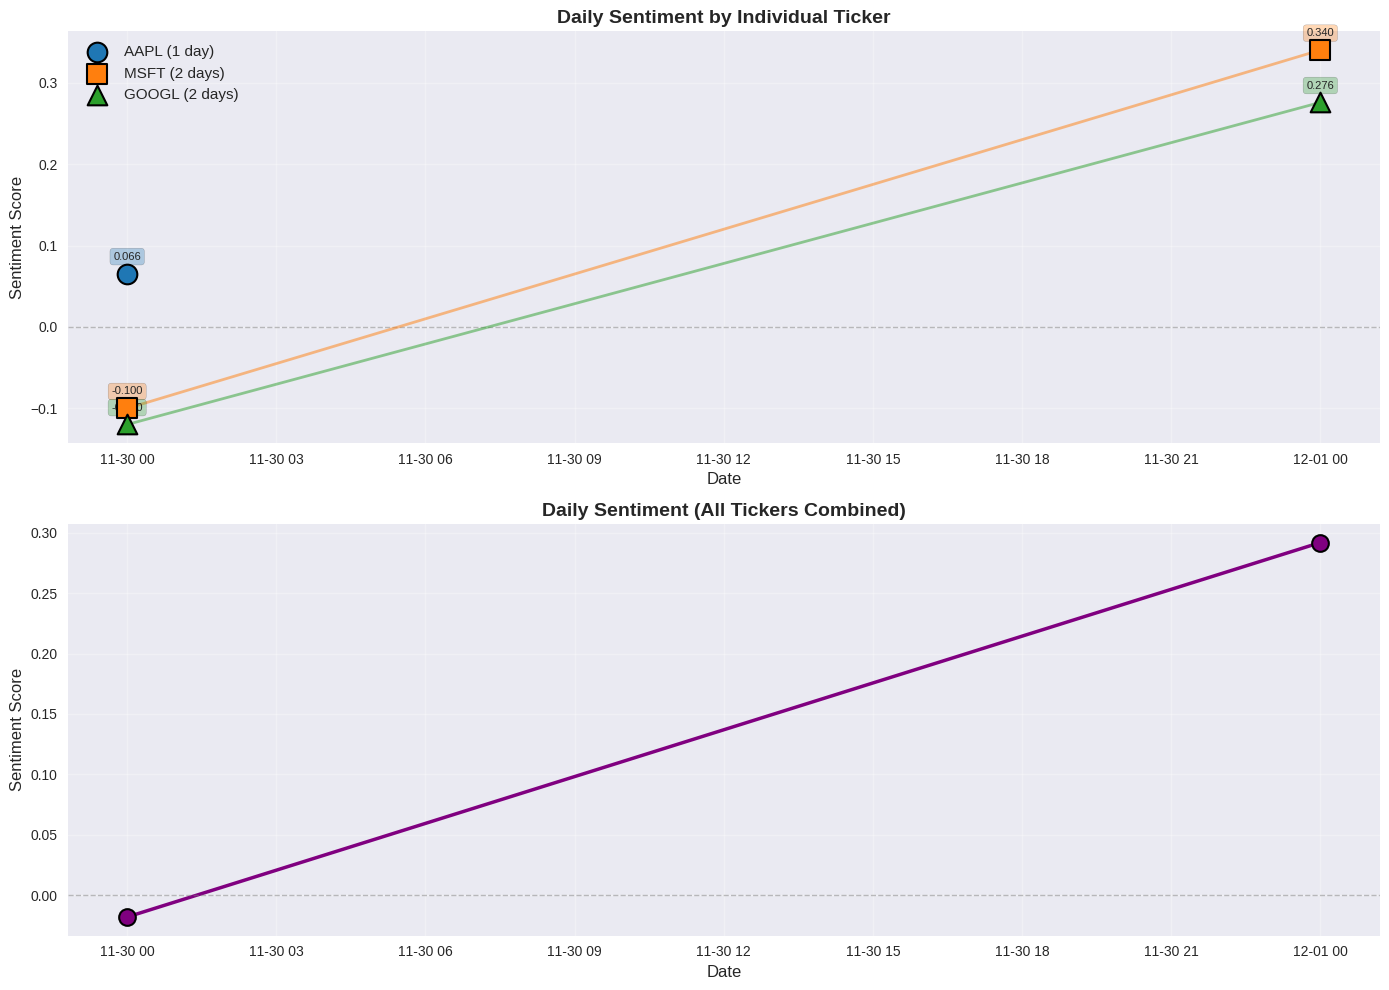


Per-Ticker Sentiment (Pivot View):
ticker         AAPL     GOOGL      MSFT
date                                   
2025-11-30  0.06563 -0.119760 -0.099975
2025-12-01  No data  0.275733  0.340000

Summary Statistics:
       sentiment                                
           count    mean     std     min     max
ticker                                          
AAPL           1  0.0656     NaN  0.0656  0.0656
GOOGL          2  0.0780  0.2797 -0.1198  0.2757
MSFT           2  0.1200  0.3111 -0.1000  0.3400


In [32]:
# ======================================
# SENTIMENT COMPARISON: COMBINED vs PER TICKER (FIXED)
# ======================================


# ======================================
#  VISUALIZATION
# ======================================
df_news["date"] = df_news["timestamp"].dt.date
df_news_clean = df_news.dropna(subset=["sentiment"])

df_daily_sent_ticker = df_news_clean.groupby(["date", "ticker"])["sentiment"].mean().reset_index()
df_daily_sent_combined = df_news_clean.groupby("date")["sentiment"].mean().reset_index()

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Per Ticker with IMPROVED visibility
colors = {'AAPL': '#1f77b4', 'MSFT': '#ff7f0e', 'GOOGL': '#2ca02c'}
markers = {'AAPL': 'o', 'MSFT': 's', 'GOOGL': '^'}  # Different shapes

for ticker in tickers:
    ticker_data = df_daily_sent_ticker[df_daily_sent_ticker["ticker"] == ticker]

    if len(ticker_data) > 0:
        # Plot with distinct markers and colors
        axes[0].scatter(ticker_data["date"], ticker_data["sentiment"],
                       label=f"{ticker} ({len(ticker_data)} day{'s' if len(ticker_data) > 1 else ''})",
                       marker=markers[ticker],
                       s=200,  # Large marker size
                       color=colors[ticker],
                       edgecolors='black',
                       linewidth=1.5,
                       zorder=5)

        # Add connecting lines only if there are multiple points
        if len(ticker_data) > 1:
            axes[0].plot(ticker_data["date"], ticker_data["sentiment"],
                        color=colors[ticker],
                        linewidth=2,
                        alpha=0.5,
                        zorder=3)

axes[0].set_title("Daily Sentiment by Individual Ticker", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Date", fontsize=12)
axes[0].set_ylabel("Sentiment Score", fontsize=12)
axes[0].legend(loc='best', fontsize=11, framealpha=0.9)
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=1)

# Add value labels on points
for ticker in tickers:
    ticker_data = df_daily_sent_ticker[df_daily_sent_ticker["ticker"] == ticker]
    for _, row in ticker_data.iterrows():
        axes[0].annotate(f'{row["sentiment"]:.3f}',
                        (row["date"], row["sentiment"]),
                        textcoords="offset points",
                        xytext=(0, 10),
                        ha='center',
                        fontsize=8,
                        bbox=dict(boxstyle='round,pad=0.3', facecolor=colors[ticker], alpha=0.3))

# Plot 2: Combined
axes[1].plot(df_daily_sent_combined["date"], df_daily_sent_combined["sentiment"],
             marker='o', color='purple', linewidth=2.5, markersize=12,
             markeredgecolor='black', markeredgewidth=1.5)
axes[1].set_title("Daily Sentiment (All Tickers Combined)", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Date", fontsize=12)
axes[1].set_ylabel("Sentiment Score", fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=1)

plt.tight_layout()
plt.show()

# ======================================
# DETAILED DATA VIEW
# ======================================
print("\n" + "="*60)
print("Per-Ticker Sentiment (Pivot View):")
print("="*60)
pivot_sentiment = df_daily_sent_ticker.pivot(index='date', columns='ticker', values='sentiment')
print(pivot_sentiment.fillna("No data"))

print("\n" + "="*60)
print("Summary Statistics:")
print("="*60)
summary = df_daily_sent_ticker.groupby('ticker').agg({
    'sentiment': ['count', 'mean', 'std', 'min', 'max']
}).round(4)
print(summary)

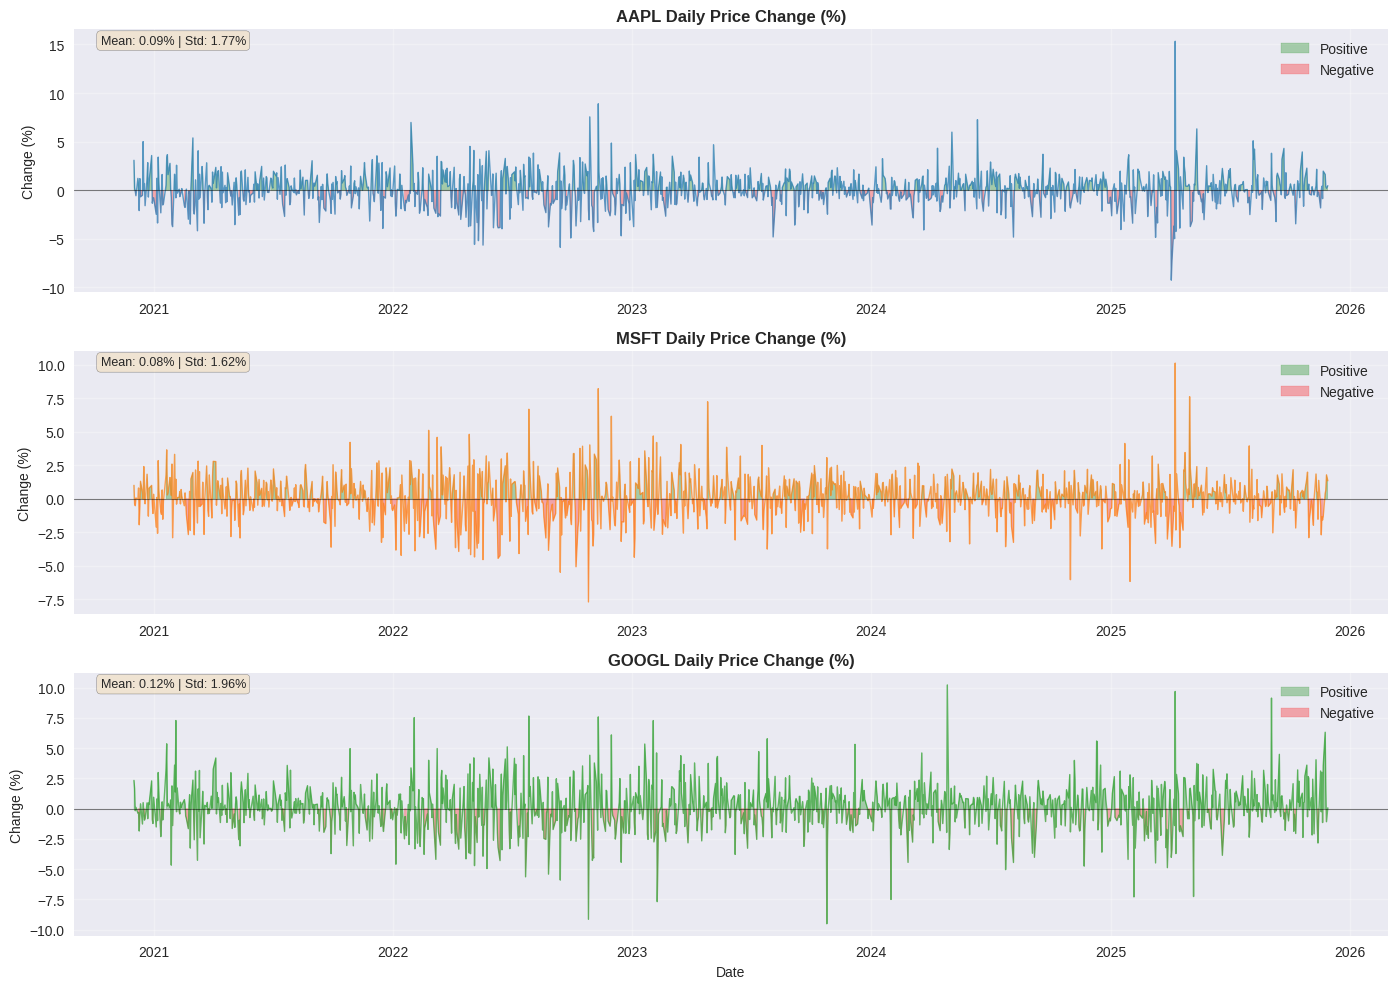

In [46]:
# ======================================
# STOCK PRICE DAILY CHANGE (PER TICKER)
# ======================================
price_changes = []
df_price['ds'] = pd.to_datetime(df_price['ds'], errors='coerce')
for ticker in tickers:
    df_t = df_price[df_price["ticker"] == ticker].copy()
    df_t["date"] = df_t["ds"].dt.date
    df_t["pct_change"] = df_t["y"].pct_change() * 100
    price_changes.append(df_t[["date", "ticker", "pct_change"]])

df_price_change = pd.concat(price_changes, ignore_index=True)

# ======================================
# VISUALIZATION
# ======================================
fig, axes = plt.subplots(3, 1, figsize=(14, 10))
colors = {'AAPL': '#1f77b4', 'MSFT': '#ff7f0e', 'GOOGL': '#2ca02c'}

for idx, ticker in enumerate(tickers):
    ticker_data = df_price_change[df_price_change["ticker"] == ticker]

    # Plot the line
    axes[idx].plot(ticker_data["date"], ticker_data["pct_change"],
                   color=colors[ticker], linewidth=1, alpha=0.7)

    # Color positive/negative changes
    axes[idx].fill_between(ticker_data["date"], ticker_data["pct_change"], 0,
                           where=(ticker_data["pct_change"] >= 0),
                           color='green', alpha=0.3, label='Positive')
    axes[idx].fill_between(ticker_data["date"], ticker_data["pct_change"], 0,
                           where=(ticker_data["pct_change"] < 0),
                           color='red', alpha=0.3, label='Negative')

    # Formatting
    axes[idx].set_title(f'{ticker} Daily Price Change (%)', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Change (%)', fontsize=10)
    axes[idx].axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend(loc='upper right')

    # Add statistics
    mean_change = ticker_data["pct_change"].mean()
    std_change = ticker_data["pct_change"].std()
    axes[idx].text(0.02, 0.98, f'Mean: {mean_change:.2f}% | Std: {std_change:.2f}%',
                   transform=axes[idx].transAxes, fontsize=9,
                   verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

axes[2].set_xlabel('Date', fontsize=10)
plt.tight_layout()
plt.show()

In [50]:
# ======================================
# MERGE SENTIMENT WITH PRICE (FOR 3 TICKERS)
# ======================================

# Clean sentiment data
df_news["date"] = df_news["timestamp"].dt.date
df_sent = df_news.dropna(subset=["sentiment"])

df_daily_sent = df_sent.groupby(["date", "ticker"])["sentiment"].mean().reset_index()

# Merge for all 3 tickers
merged_dfs = {}

for ticker in tickers:
    # Filter merged data for this ticker
    df_ticker = df_merged_full[df_merged_full["ticker"] == ticker].copy()
    merged_dfs[ticker] = df_ticker
    print(f"Created DataFrame for {ticker}: {len(df_ticker)} rows")

print("Merged data created for:", list(merged_dfs.keys()))
merged_dfs[tickers[0]].head()


Created DataFrame for AAPL: 1256 rows
Created DataFrame for MSFT: 1256 rows
Created DataFrame for GOOGL: 1256 rows
Merged data created for: ['AAPL', 'MSFT', 'GOOGL']


,ds,Open,High,Low,y,Volume,ticker,sentiment
0,2020-11-30,113.864721,117.758530,113.708965,115.889503,169410200,AAPL,0.0
1,2020-12-01,117.797449,120.192141,116.823997,119.462051,127728200,AAPL,0.0
2,2020-12-02,118.780643,120.094810,117.680645,119.812508,89004200,AAPL,0.0
3,2020-12-03,120.240820,120.493920,118.965600,119.676224,78967600,AAPL,0.0
4,2020-12-04,119.345262,119.598361,118.293931,119.004555,78260400,AAPL,0.0


In [52]:
# ======================================
# FEATURE ENGINEERING FOR EACH TICKER
# ======================================

for ticker in tickers:
    df = merged_dfs[ticker].copy()


    price_col = "Close" if "Close" in df.columns else "y"

    df["return"] = df[price_col].pct_change()
    df["volatility"] = df["return"].rolling(7).std()
    df["ma7"] = df[price_col].rolling(7).mean()
    df["ma30"] = df[price_col].rolling(30).mean()
    df["sentiment_ma3"] = df["sentiment"].rolling(3).mean()

    merged_dfs[ticker] = df.dropna()

    print(f"\n{ticker} features:")
    print(f"  Rows after dropna: {len(merged_dfs[ticker])}")
    print(f"  Columns: {merged_dfs[ticker].columns.tolist()}")
    print(merged_dfs[ticker].tail())

print("\n✅ Feature engineering complete.")



AAPL features:
  Rows after dropna: 1227
  Columns: ['ds', 'Open', 'High', 'Low', 'y', 'Volume', 'ticker', 'sentiment', 'return', 'volatility', 'ma7', 'ma30', 'sentiment_ma3']
              ds        Open        High         Low           y    Volume ticker  sentiment    return  volatility         ma7        ma30  sentiment_ma3
1251  2025-11-21  265.950012  273.329987  265.670013  271.489990  59030800   AAPL        0.0  0.019681    0.011618  269.508571  264.891609            0.0
1252  2025-11-24  270.899994  277.000000  270.899994  275.920013  65585800   AAPL        0.0  0.016317    0.013297  269.932857  265.841605            0.0
1253  2025-11-25  275.269989  280.380005  275.250000  276.970001  46914200   AAPL        0.0  0.003805    0.013215  270.584285  266.822937            0.0
1254  2025-11-26  276.959991  279.529999  276.630005  277.549988  33431400   AAPL        0.0  0.002094    0.009696  272.025713  267.771319            0.0
1255  2025-11-28  277.260010  279.000000  275.989990 

In [53]:
# ======================================
# PREPARE PROPHET DATA FOR ALL 3 TICKERS
# ======================================

prophet_ready = {}

for ticker in tickers:
    df = merged_dfs[ticker].copy()

    # Prophet requires ds + y
    df_basic = df.reset_index().rename(columns={"Date": "ds", "Close": "y"})

    # With sentiment
    df_sent = df_basic.copy()
    df_sent["sentiment"] = df["sentiment"].values  # Add regressor

    prophet_ready[ticker] = {
        "basic": df_basic,
        "sent": df_sent
    }

print("Prophet datasets ready for all tickers.")


Prophet datasets ready for all tickers.


In [54]:
# ======================================
# TRAIN PROPHET MODELS
# ======================================

from prophet import Prophet

forecast_results = {}

for ticker in tickers:
    print(f"\nTraining models for {ticker} ...")

    # -------- BASELINE MODEL --------
    m_basic = Prophet()
    m_basic.fit(prophet_ready[ticker]["basic"])

    future_basic = m_basic.make_future_dataframe(periods=30)
    forecast_basic = m_basic.predict(future_basic)

    # -------- SENTIMENT MODEL --------
    m_sent = Prophet()
    m_sent.add_regressor("sentiment")
    m_sent.fit(prophet_ready[ticker]["sent"])

    df_future_sent = prophet_ready[ticker]["sent"].copy()
    extra = pd.DataFrame({
        "ds": pd.date_range(df_future_sent["ds"].max() + pd.Timedelta(days=1),
                            periods=30,
                            freq="D")
    })
    # New days have no sentiment → assume neutral (0)
    extra["sentiment"] = 0

    df_future_sent = pd.concat([df_future_sent, extra], ignore_index=True)
    forecast_sent = m_sent.predict(df_future_sent)

    forecast_results[ticker] = {
        "basic": forecast_basic,
        "sent": forecast_sent
    }

print("\nAll Prophet models trained successfully.")



Training models for AAPL ...


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Training models for MSFT ...


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Training models for GOOGL ...


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



All Prophet models trained successfully.


In [55]:
# ======================================
# MODEL PERFORMANCE COMPARISON (RMSE)
# ======================================

from sklearn.metrics import mean_squared_error
import numpy as np

comparison_rows = []

for ticker in tickers:
    df_true = prophet_ready[ticker]["basic"]["y"].values

    # Align predictions with actual dates
    pred_basic = forecast_results[ticker]["basic"].iloc[:len(df_true)]["yhat"].values
    pred_sent = forecast_results[ticker]["sent"].iloc[:len(df_true)]["yhat"].values

    rmse_basic = np.sqrt(mean_squared_error(df_true, pred_basic))
    rmse_sent = np.sqrt(mean_squared_error(df_true, pred_sent))

    comparison_rows.append([ticker, rmse_basic, rmse_sent])

df_compare = pd.DataFrame(comparison_rows,
                          columns=["Ticker", "RMSE_Basic", "RMSE_With_Sentiment"])

df_compare


,Ticker,RMSE_Basic,RMSE_With_Sentiment
0,AAPL,9.669189,9.669189
1,MSFT,14.827308,14.827308
2,GOOGL,10.618355,10.618355


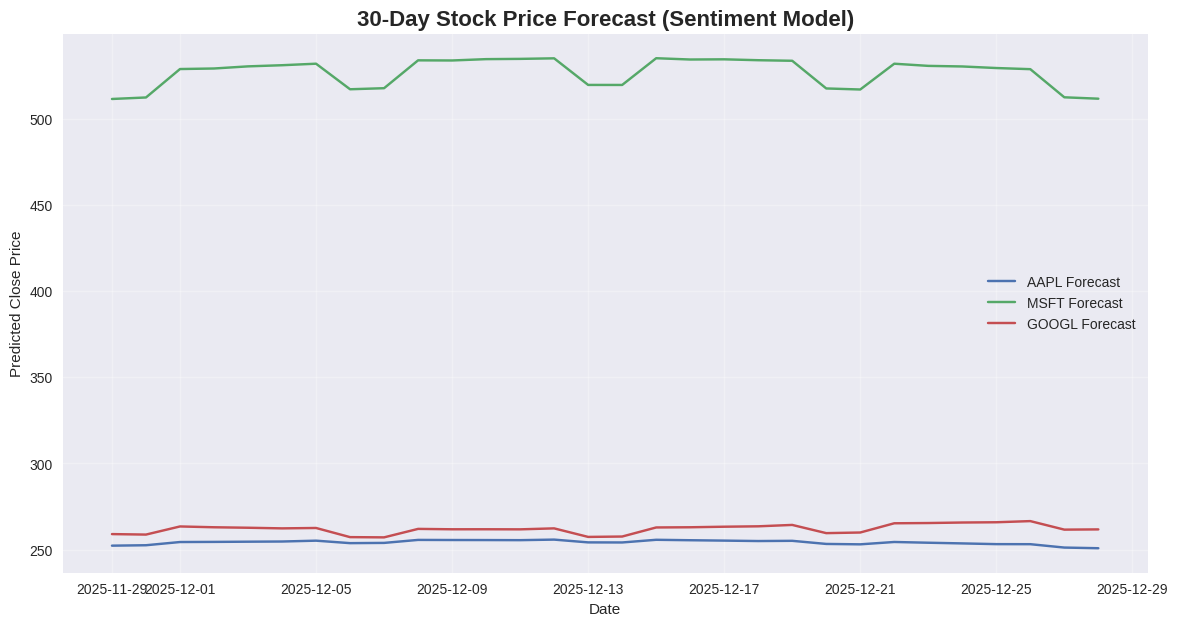

In [57]:
# ======================================
# VISUALIZE 30-DAY FORECAST FOR EACH TICKER
# ======================================

fig, ax = plt.subplots(figsize=(14, 7))

for ticker in tickers:
    forecast = forecast_results[ticker]["sent"].set_index("ds").tail(30)
    ax.plot(forecast.index, forecast["yhat"], label=f"{ticker} Forecast")

ax.set_title("30-Day Stock Price Forecast (Sentiment Model)", fontsize=16, fontweight='bold')
ax.set_xlabel("Date")
ax.set_ylabel("Predicted Close Price")
ax.grid(True, alpha=0.3)
ax.legend()

plt.show()
